IDEA

1. skip connection
2. Receptive Field
3. 1x1 convolution

# Implementation CNN
> 1. Dataset
    >> `CIFAR10`
    >> - 학습 데이터는 data_batch_1, data_batch_2, ..., data_batch_5, 테스트 데이터는 test_batch 파일이 pickled 상태로 존재한다.
    >> - pickled 파일은 dictionary 이며 keys 는 다음과 같다. **dict_keys([b'batch_label', b'labels', b'data', b'filenames'])**
    >> - 데이터는 32x32 colour image 이며, 각 batch 파일의 이미지는 10000 x 3072 형태로 구성되어 있다. 이떄 R, G, B 순서로 1024 개의 values 가 존재한다.
    >> 총 50,000 개의 학습데이터와 10,000 개의 테스트데이터가 존재한다.
> 2. Model
    >> - VGG 모델은 11 개의 layerm 13 개의 layer, 16개의 layer, 19개의 layer 를 3 x 3 convolution layer 로만 쌓는 시도를 하였다.
    >> - ReLU activation 을 이용하며, 모든 convolution 이후 batch-normalization 을 사용한다.
    >> - 기존 kernel 을 11x11, 7x7, 5x5 등 더 넓게 사용하였지만, VGG 에서는 3x3 convolution layer 만을 사용하여 모델을 더 깊게 만들 수 있었다.
    >> - 의의 - `깊이의 중요성` 모델의 깊이가 깊어짐에 따라, 이미지의 저수준 특징부터 고수준의 추상적인 특징까지 계층적으로 학습할 수 있었다.
    >>
    >> 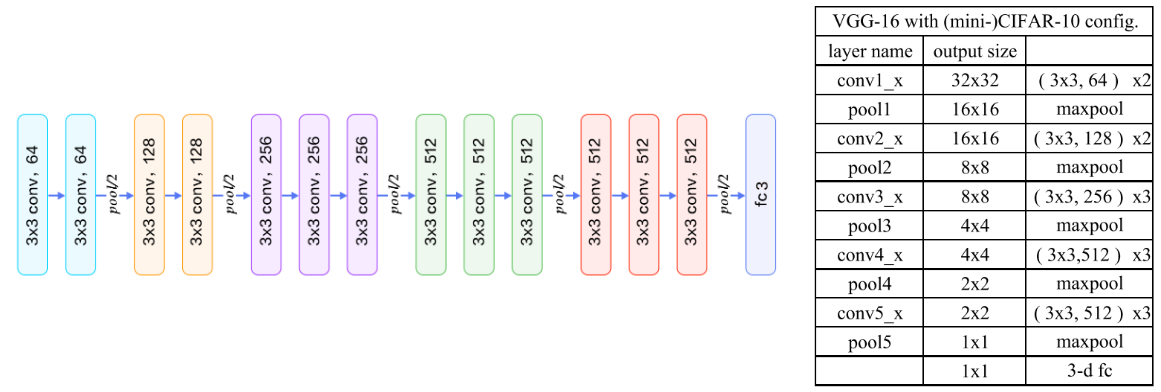
> 3. Training & Evaluation
    >> - **Loss function**: `Cross-entropy loss` -> ***nn.CrossEntropy method*** 는 모델의 출력을 softmax 이후 `Cross-entropy loss` 가 계산된다.
    >> - **Default weight initialization** -> ***kaiming_uniform***방식으로 초기화 된다.
    >> - **parameters** - > `wandb` 를 통해 적절한 하이퍼파라미터를 구성해본다.

### 환경설정

In [1]:
import os # 파일이나 디렉토리 조작이 가능하고, 파일의 목록이나 path를 얻을 수 있다
import numpy as np # 기본적인 연산을 위한 라이브러리
import pickle # 파이썬 객체의 자료형을 변환 하지않고 그대로 파일로 저장하고 이를 불러올 때 사용하는 모듈
import matplotlib.pyplot as plt # 그림이나 그래프를 그리기 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리
import math # 수학 계산을 위한 라이브러
import time

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리
from torchvision.transforms import Compose, ToTensor, Normalize # 데이터셋의 pytorch 에서 사용하기 위해 변환시키는 method
import torch.nn.functional as F # torch에서 수학적인 function을 쉽게 불러오기 위한 라이브러리

import torchvision.transforms as T # 이미지의 다양성을 주기 위한 라이브러리
import torchvision # torch에서 이미지를 처리하기 위한 라이브러
import torchvision.utils as vutils # torch로 구성된 이미지를 쉽게 구성하기 위한 라이브러리

from sklearn.metrics import accuracy_score # 정확도 성능지표 측정

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
# Hyper parameter
verbose = True

if torch.cuda.is_available():
    device = 'cuda:0' # gpu 설정
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
    
device

'cuda:0'

## 1. Dataset

In [4]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class CIFAR10Dataset(Dataset):
    '''
        pickled file 로 저장된 CIFAR10 을 불러오기 위해 Custom Dataset class 을 구성한다.
    '''
    def __init__(self, data_dir, train=True, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        self._load_cifar10(train=train)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        # 텐서의 차원을 [높이, 너비, 채널]에서 [채널, 높이, 너비]로 변경
        if self.transform:
            img = np.transpose(img, (1, 2, 0))
            img = self.transform(img)
        return img, label
    
    # 데이터는 잘 불러와졌는가?
    @ staticmethod
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  
        
    def _load_cifar10(self, train=True):
        if train:
            for i in range(1, 6):
                file_path = os.path.join(self.data_dir, f'cifar-10-batches-py/data_batch_{i}')
                data, labels = self._load_pickled_cifar10(file_path)
                self.data.append(data)
                self.labels += labels
            self.data = np.concatenate(self.data)
        else:
            file_path = os.path.join(self.data_dir, 'cifar-10-batches-py/test_batch')
            self.data, self.labels = self._load_pickled_cifar10(file_path)
            
        self.data = self.data.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0
                    
    def _load_pickled_cifar10(self, path):
        
        with open(path, 'rb') as f:
            dict = pickle.load(f, encoding='bytes')
        
        data = dict[b'data']
        labels = dict[b'labels']
        return data, labels

In [5]:
# load dataset
transform = Compose([
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
# 텐서의 차원을 [높이, 너비, 채널]에서 [채널, 높이, 너비]로 변경하므로
# Dataset class 내에서 __getitem__ 정의에서 주의하기.

train_dataset = CIFAR10Dataset(data_dir=os.getcwd(), train=True, transform=transform)
test_dataset = CIFAR10Dataset(data_dir=os.getcwd(), train=False, transform=transform)

In [6]:
# train_loader_sample = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=4, 
#                                            shuffle=True)

# # Get a batch of training data
# inputs, classes = next(iter(train_loader_sample))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# CIFAR10Dataset.imshow(out, title=[class_names[x] for x in classes])

## 2. Model (Network Architecture)

In [7]:
# 모델의 아웃풋 채널의 수와 maxpooling (M)으로 미리 정의하여 모델의 구조를 미리 정의합니다.
# VGG 다음에 나타난 숫자는 convolution layer의 개수(Maxpooling layer 제외)와 리스트에 정의되지 않은 fc layer의 개수(3개)도 포함됩니다.
cfgs = {'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']}

In [8]:
class VGG(nn.Module):
    def __init__(self, architecture, in_channels, num_classes):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv_layers = self.create_conv_layers(cfg=cfgs[architecture])
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        '''
        INPUT:
            x - [batch_size, channel, width, height]
        OUTPUT:
            y = [batch_size, num_classes]

        '''
        x = self.conv_layers(x) # [BATCH_SIZE, num_features, width, height]
        x = torch.flatten(x, start_dim=1) # 첫 번째 차원(0차원) 이후의 모든 차원을 평탄화한다
        x = self.fc_layers(x)
        return x


    def create_conv_layers(self, cfg):
        layers = []
    
        for e in cfg:
            if isinstance(e, int):
                out_channels = e
                layers += [
                    nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(e),
                    nn.ReLU(inplace=True),
                ]
                self.in_channels = e
            else:
                layers.append(nn.MaxPool2d(kernel_size=2))
        
        # unpacking the layers
        return nn.Sequential(*layers) 

        


## 3. Training & Evaluation

In [9]:
def _training(model, dataloader, train_dataset, criterion, optimizer):
    # 모델을 학습 모드로 설정
    model.train()
    train_loss = 0.0
    train_accurary = 0

    for images, labels in dataloader:

        # USE GPU FOR MODEL
        images = images.to(device)
        labels = labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad() # 이전 그래디언트 초기화
        loss.backward()
        optimizer.step()

        # 손실과 정확도 계산
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # 최댓값과 최댓값에 해당하는 라벨 반환
        train_accurary += (predicted == labels).sum().item()

    train_loss = train_loss / len(dataloader) # loss 값은 batch 에 대한 계산이므로 dataloader의 길이에 대해 나누고
    train_accurary = train_accurary / len(train_dataset) # accuray 값은 각각의 데이터에 대한 정확도 여부이므로 데이터셋의 길이에 대해서 나눔

    return model, train_loss, train_accurary

def _evaluation(model, dataloader, valid_dataset, criterion):
    # 모델을 평가 모드로 설정
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad(): # model 의 업데이트 방지
        for images, labels in dataloader:
            # USE GPU FOR MODEL
            images = images.to(device)
            labels = labels.to(device)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)

            # loss & accuracy 계산
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # 최댓값과 최댓값에 해당하는 라벨 반환
            valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(dataloader) 
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs, patience, model_name):
    print('TRAIN THE MODEL')
    # 가장 좋은 validation loss 를 저장
    best_valid_loss = float('inf')
    early_stop_counter = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):

        start_time = time.time()
        
        model, train_loss, train_accurary = _training(model, train_dataloader, train_dataset, criterion, optimizer)
        valid_loss, valid_accuracy = _evaluation(model, valid_dataloader, valid_dataset, criterion)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0
        else: 
            # validation loss 가 증가하거나 같으면 카운터가 증가
            early_stop_counter += 1

        # 조기종료 카운터가 설정한 patience 를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print(f'Early stop - Epoch [{epoch + 1}/{num_epochs}]')
            break
        
        if epoch % 3 == 0:
            elpased_time = time.time() - start_time
            msg = f"\033[31m[Elpased Time: {elpased_time}]\033[0m "
            msg += f"Iter: {epoch+1} "
            msg += f"Train Loss : {train_loss:.4f} "
            msg += f"Train Acc : {train_accurary:.2f} "
            msg += f"Valid Loss : {valid_loss:.4f} "
            msg += f"Valid Acc : {valid_accuracy:.2f} "
            print(msg)

    return model, valid_max_accuracy

            

In [10]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
print("Test dataset 개수 :", len(test_dataset))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  40000
Validation dataset 개수 :  10000
Test dataset 개수 : 10000


In [11]:
# 앞서 선언한 Dataset 을 인자로 주어 DataLoader 를 선언
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
model_name = 'VGG16'
in_channels = 3
out_channels = 10
model = VGG(model_name, in_channels, out_channels)
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

The number of parameters :  33646666


VGG(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


In [14]:
num_epochs = 50
patience = 10
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs, patience, model_name)
print(f'{model_name} valid max accuracy : ', valid_max_accuracy)

TRAIN THE MODEL
[Elpased Time: 30.565880060195923] Iter: 1 Train Loss : 1.6748 Train Acc : 0.36 Valid Loss : 1.2874 Valid Acc : 0.54 
[Elpased Time: 27.906290769577026] Iter: 4 Train Loss : 0.7588 Train Acc : 0.75 Valid Loss : 0.7878 Valid Acc : 0.73 
[Elpased Time: 29.763939380645752] Iter: 7 Train Loss : 0.4932 Train Acc : 0.84 Valid Loss : 0.6390 Valid Acc : 0.80 
[Elpased Time: 30.656208038330078] Iter: 10 Train Loss : 0.3488 Train Acc : 0.89 Valid Loss : 0.5908 Valid Acc : 0.80 
[Elpased Time: 30.579726457595825] Iter: 13 Train Loss : 0.2497 Train Acc : 0.92 Valid Loss : 0.5487 Valid Acc : 0.84 
[Elpased Time: 30.71341586112976] Iter: 16 Train Loss : 0.1982 Train Acc : 0.94 Valid Loss : 0.5537 Valid Acc : 0.84 
[Elpased Time: 29.144169569015503] Iter: 19 Train Loss : 0.1631 Train Acc : 0.95 Valid Loss : 0.6052 Valid Acc : 0.84 
Early stop - Epoch [22/50]
VGG16 valid max accuracy :  0.8421
